In [1]:
from mylib.statistic_test import *

code_id = '0871 - Novel routes do not affect R1 behavior'
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0871 - Novel routes do not affect R1 behavior is already existed!


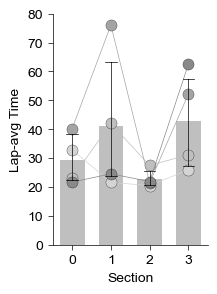

In [59]:
def mean_time_per_lap(trace):
    beg, end = LapSplit(trace, "DSPMaze")
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, maze_type=1)
    lap_mid_time = (trace['correct_time'][beg] + trace['correct_time'][end]) / 2
    
    avg_navigation_time = np.zeros(4)
    for i, n in enumerate([0,4,5,9]):
        lap_idx = np.where(
            (lap_mid_time >= trace[f'node {n}']['ms_time_behav'][0]) & 
            (lap_mid_time < trace[f'node {n}']['ms_time_behav'][-1])
        )[0]
        lapwise_time = trace['correct_time'][end[lap_idx]] - trace['correct_time'][beg[lap_idx]]
        avg_navigation_time[i] = np.mean(lapwise_time)
        
    return avg_navigation_time

if exists(join(figdata, f"{code_id} [lapwise time].pkl")) == False:
    LapwiseTimeData = {
        "MiceID": [],
        "Session": [],
        "Section": [],
        "Lap-avg Time": []
    }
    for mouse in [10212, 10224, 10227, 10232]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for s in tqdm(range(7)):
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace = pickle.load(f)
                
            avg_time = mean_time_per_lap(trace)
            LapwiseTimeData["MiceID"].append(np.repeat(mouse, 4))
            LapwiseTimeData["Session"].append(np.repeat(s, 4))
            LapwiseTimeData["Section"].append(np.arange(4))
            LapwiseTimeData["Lap-avg Time"].append(avg_time/1000)
            
    for key in LapwiseTimeData:
        LapwiseTimeData[key] = np.concatenate(LapwiseTimeData[key])
    with open(join(figdata, f"{code_id} [lapwise time].pkl"), 'wb') as f:
        pickle.dump(LapwiseTimeData, f)
    
    LapwiseTimeD = pd.DataFrame(LapwiseTimeData)
    LapwiseTimeD.to_excel(join(figdata, f"{code_id} [lapwise time].xlsx"), index=False)
    print(len(LapwiseTimeD))
else:
    with open(join(figdata, f"{code_id} [lapwise time].pkl"), 'rb') as f:
        LapwiseTimeData = pickle.load(f)

LapwiseTimeData['X'] = LapwiseTimeData['Session'] * 4 + LapwiseTimeData['Section']
subdata = SubDict(LapwiseTimeData, LapwiseTimeData.keys(), np.where(LapwiseTimeData['Session'] == 0)[0])
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Section',
    y='Lap-avg Time',
    data=subdata,
    hue='MiceID',
    palette=sns.color_palette("Grays", 10)[2:6],
    marker='o',
    markeredgewidth=0.2,
    markersize=8,
    markeredgecolor='k',
    err_style="bars",
    ax=ax,
    err_kws={"capsize": 5, "capthick": 1},
    linewidth=0.5,
    legend=False
)
sns.barplot(
    x='Section',
    y='Lap-avg Time',
    data=subdata,
    color='gray',
    alpha=0.5,
    ax=ax,
    capsize=0.3,
    gap=0.2,
    err_kws={"color": 'k', "linewidth": 0.5},
    zorder=0
)
ax.set_ylim(0, 80)
plt.savefig(join(loc, f"lapwise avg time.svg"))
plt.savefig(join(loc, f"lapwise avg time.png"), dpi=600)
plt.show()


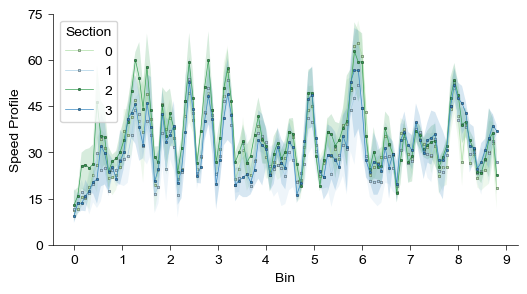

In [60]:
def speed_profile(trace):
    beg, end = LapSplit(trace, "DSPMaze")
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, maze_type=1)
    lap_mid_time = (trace['correct_time'][beg] + trace['correct_time'][end]) / 2
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    speed_profiles = np.zeros((4, 111))
    
    dx = np.diff(trace['correct_pos'][:, 0])/10
    dy = np.diff(trace['correct_pos'][:, 1])/10
    dt = np.diff(trace['correct_time']) / 1000
    speed = np.sqrt(dx**2 + dy**2) / dt
    speed[dt > 10] = np.nan
    speed = np.append(speed, speed[-1])
    
    for i, n in enumerate([0,4,5,9]):
        for j, b in enumerate(CP_DSPs[1][0]):
            idx = np.where(
                (trace['correct_time'] >= trace[f'node {n}']['ms_time_behav'][0]) &
                (trace['correct_time'] < trace[f'node {n}']['ms_time_behav'][-1]) &
                (behav_nodes == b)
            )
            if len(idx[0]) > 0:
                speed_profiles[i, j] = np.nanmean(speed[idx])
            else:
                speed_profiles[i, j] = np.nan
    
    return speed_profiles

if exists(join(figdata, f"{code_id} [speed profile].pkl")) == False:
    SpeedProfileData = {
        "MiceID": [],
        "Session": [],
        "Section": [],
        "Bin": [],
        "Speed Profile": []
    }
    for mouse in [10212, 10224, 10227, 10232]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for s in tqdm(range(7)):
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace = pickle.load(f)
                
            speed_profile_data = speed_profile(trace)
            for i in range(4):
                SpeedProfileData["MiceID"].append(np.repeat(mouse, 111))
                SpeedProfileData["Session"].append(np.repeat(s, 111))
                SpeedProfileData["Section"].append(np.repeat(i, 111))
                SpeedProfileData["Bin"].append(np.arange(111))
                SpeedProfileData["Speed Profile"].append(speed_profile_data[i, :])
            
    for key in SpeedProfileData:
        SpeedProfileData[key] = np.concatenate(SpeedProfileData[key])
    with open(join(figdata, f"{code_id} [speed profile].pkl"), 'wb') as f:
        pickle.dump(SpeedProfileData, f)
    
    SpeedProfileD = pd.DataFrame(SpeedProfileData)
    SpeedProfileD.to_excel(join(figdata, f"{code_id} [speed profile].xlsx"), index=False)
    print(len(SpeedProfileD))
else:
    with open(join(figdata, f"{code_id} [speed profile].pkl"), 'rb') as f:
        SpeedProfileData = pickle.load(f)
        
SpeedProfileData['X'] = SpeedProfileData['Session'] * 4 + SpeedProfileData['Section']
subdata = SubDict(SpeedProfileData, SpeedProfileData.keys(), np.where(SpeedProfileData['Session'] == 0)[0])
fig = plt.figure(figsize=(6, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='Speed Profile',
    data=subdata,
    hue='Section',
    palette=[
        sns.color_palette("Greens", 2)[0], 
        sns.color_palette("Blues", 2)[0], 
        sns.color_palette("Greens", 2)[1], 
        sns.color_palette("Blues", 2)[1]
    ],
    marker='o',
    markeredgewidth=0.2,
    markersize=2,
    linewidth=0.5,
    markeredgecolor='k',
    ax=ax,
    err_kws={"edgecolor": None}
)
ax.set_ylim(0,75)
ax.set_yticks(np.linspace(0, 75, 6))
ax.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10).astype(int))
plt.savefig(join(loc, f"speed profile.svg"))
plt.savefig(join(loc, f"speed profile.png"), dpi=600)
plt.show()

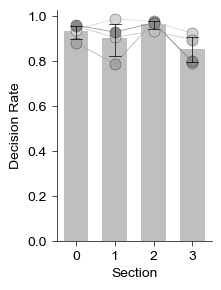

In [58]:
def decision_rate(trace):
    beg, end = LapSplit(trace, "DSPMaze")
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, maze_type=1)
    lap_mid_time = (trace['correct_time'][beg] + trace['correct_time'][end]) / 2
    
    decision_rates = np.zeros(4)
    for i, n in enumerate([0,4,5,9]):
        lap_idx = np.where(
            (lap_mid_time >= trace[f'node {n}']['ms_time_behav'][0]) & 
            (lap_mid_time < trace[f'node {n}']['ms_time_behav'][-1])
        )[0]
        decision_rate_lap = lap_wise_decision_rate(trace)
        if len(lap_idx) > 0:
            decision_rates[i] = np.nanmean(decision_rate_lap[lap_idx])
        else:
            decision_rates[i] = np.nan
            
    return decision_rates

if exists(join(figdata, f"{code_id} [decision rate].pkl")) == False:
    DecisionRateData = {
        "MiceID": [],
        "Session": [],
        "Section": [],
        "Decision Rate": []
    }
    for mouse in [10212, 10224, 10227, 10232]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for s in tqdm(range(7)):
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace = pickle.load(f)
                
            decision_rate_data = decision_rate(trace)
            DecisionRateData["MiceID"].append(np.repeat(mouse, 4))
            DecisionRateData["Session"].append(np.repeat(s, 4))
            DecisionRateData["Section"].append(np.arange(4))
            DecisionRateData["Decision Rate"].append(decision_rate_data)
            
    for key in DecisionRateData:
        DecisionRateData[key] = np.concatenate(DecisionRateData[key])
    with open(join(figdata, f"{code_id} [decision rate].pkl"), 'wb') as f:
        pickle.dump(DecisionRateData, f)
    
    DecisionRateD = pd.DataFrame(DecisionRateData)
    DecisionRateD.to_excel(join(figdata, f"{code_id} [decision rate].xlsx"), index=False)
    print(len(DecisionRateD))
else:
    with open(join(figdata, f"{code_id} [decision rate].pkl"), 'rb') as f:
        DecisionRateData = pickle.load(f)
        
DecisionRateData['X'] = DecisionRateData['Session'] * 4 + DecisionRateData['Section']
subdata = SubDict(DecisionRateData, DecisionRateData.keys(), np.where(DecisionRateData['Session'] == 0)[0])
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Section',
    y='Decision Rate',
    data=subdata,
    hue='MiceID',
    palette=sns.color_palette("Grays", 10)[2:6],
    marker='o',
    markeredgewidth=0.2,
    markersize=8,
    markeredgecolor='k',
    err_style="bars",
    ax=ax,
    err_kws={"capsize": 5, "capthick": 1},
    legend=False,
    linewidth=0.5
)
sns.barplot(
    x='Section',
    y='Decision Rate',
    data=subdata,
    color='gray',
    alpha=0.5,
    ax=ax,
    capsize=0.3,
    gap=0.2,
    err_kws={"color": 'k', "linewidth": 0.5},
    zorder=0
)
ax.set_ylim(0, 1.03)
plt.savefig(join(loc, f"decision rate.svg"))
plt.savefig(join(loc, f"decision rate.png"), dpi=600)
plt.show()